In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import torch 
from transformers import AwqConfig, AutoTokenizer, AutoModelForCausalLM, TextStreamer, GenerationConfig, BitsAndBytesConfig
from awq import AutoAWQForCausalLM


base_path = '/data/sonald/ai_models/model_weights'
model_name = 'TheBloke/Mistral-7B-Instruct-v0.2-AWQ'

use_fuse = True 

if use_fuse:
    model_path = os.path.join(base_path, model_name)
    model = AutoAWQForCausalLM.from_quantized(model_path, safetensors=True, device_map='auto')
else:
    model_name = 'Mistral-7B-v0.1'
    model_path = os.path.join(base_path, model_name)
    awq_config = AwqConfig(
        bits=4,
        do_fuse=True,
        fuse_max_seq_len=512,
    )

    # model = AutoModelForCausalLM.from_pretrained(model_path, quantization_config=awq_config, device_map='auto')

    # model = AutoModelForCausalLM.from_pretrained(model_path, load_in_4bit=True,
    #                                               torch_dtype=torch.bfloat16, device_map='auto')
    # model = AutoModelForCausalLM.from_pretrained(model_path, load_in_8bit=True, torch_dtype=torch.bfloat16, device_map='auto')

model.generation_config = GenerationConfig.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

/home/uos/miniconda3/envs/vllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fusing layers...: 100%|██████████| 32/32 [00:02<00:00, 15.43it/s]


In [3]:
model

MistralAWQForCausalLM(
  (model): MistralForCausalLM(
    (model): LlamaLikeModel(
      (embedding): Embedding(32000, 4096, padding_idx=0)
      (norm): MistralRMSNorm()
    )
    (lm_head): Linear(in_features=4096, out_features=32000, bias=False)
  )
)

In [4]:
from time import time
from typing import List 

streamer = TextStreamer(tokenizer)

def predict(prompt: str, max_length=2048):
    chat = [{'role': 'user', 'content': prompt}]
    input_ids = tokenizer.apply_chat_template(chat, tokenize=True, add_generation_prompt=True,
                                                return_tensors='pt').to('cuda')

    outputs = model.generate(input_ids, streamer=streamer, max_new_tokens=max_length,
                              do_sample=True, use_cache=True,
                              top_k=50, top_p=0.95, num_return_sequences=1)
    response = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    print(f"tokens: #{len(outputs[0])}")
    return response


In [5]:
from pprint import pprint
resp = predict("write a bottom-up mergesort in rust", max_length=512)

<s> [INST] write a bottom-up mergesort in rust [/INST] Merge sort is a divide-and-conquer algorithm, but it can also be implemented bottom-up. Here's a possible implementation of bottom-up merge sort in Rust.

```rust
fn merge<T: Ord + Clone>(left: Vec<T>, right: Vec<T>) -> Vec<T> {
   let mut result = Vec::new();
   let mut i = 0;
   let mut j = 0;

   while i < left.len() && j < right.len() {
       if left[i] <= right[j] {
           result.push(left[i]);
           i += 1;
       } else {
           result.push(right[j]);
           j += 1;
       }
   }

   while i < left.len() {
       result.push(left[i]);
       i += 1;
   }

   while j < right.len() {
       result.push(right[j]);
       j += 1;
   }

   result
}

fn merge_sort<T: Ord + Clone>(arr: &[T]) -> Vec<T> {
   let len = arr.len();
   if len <= 1 {
       return arr.to_vec();
   }

   let half = len / 2;

   let left = merge_sort(&arr[..half]));
   let right = merge_sort(&arr[half..]);

   merge(left, right)
}

fn main

In [6]:
import torch.nn.functional as F
x = torch.randn(2, 8)
print(f"{F.log_softmax(x, dim=-1)=}")
print(f"{F.softmax(x, dim=-1)=}")

F.log_softmax(x, dim=-1)=tensor([[-4.1412, -2.8746, -0.4035, -2.4222, -4.0292, -4.7133, -3.2348, -2.2554],
        [-1.1047, -1.5318, -2.9772, -2.8089, -2.9890, -4.1603, -3.9602, -1.3612]])
F.softmax(x, dim=-1)=tensor([[0.0159, 0.0564, 0.6680, 0.0887, 0.0178, 0.0090, 0.0394, 0.1048],
        [0.3313, 0.2161, 0.0509, 0.0603, 0.0503, 0.0156, 0.0191, 0.2563]])


In [7]:
import torch
import numpy
from einops import rearrange, reduce, repeat
from utils import display_np_arrays_as_images

display_np_arrays_as_images()

ims = numpy.load('./einops/docs/resources/test_images.npy', allow_pickle=False)
# There are 6 images of shape 96x96 with 3 color channels packed into tensor
print(ims.shape, ims.dtype)

x = torch.randint(0, 10, (2, 8, 8))
x

(6, 96, 96, 3) float64


tensor([[[1, 6, 8, 1, 2, 6, 5, 5],
         [6, 6, 7, 3, 1, 8, 7, 3],
         [0, 3, 1, 0, 7, 3, 3, 8],
         [7, 9, 4, 6, 9, 0, 2, 4],
         [7, 8, 1, 9, 8, 6, 6, 6],
         [5, 4, 1, 5, 8, 5, 5, 4],
         [9, 6, 6, 6, 2, 2, 0, 1],
         [1, 8, 8, 3, 9, 4, 9, 8]],

        [[6, 8, 6, 5, 2, 5, 1, 2],
         [8, 6, 4, 9, 8, 9, 4, 8],
         [6, 2, 3, 9, 9, 6, 9, 0],
         [0, 7, 3, 2, 0, 0, 0, 8],
         [7, 4, 4, 7, 3, 4, 1, 4],
         [9, 4, 2, 2, 8, 4, 1, 3],
         [2, 0, 3, 9, 3, 7, 4, 8],
         [7, 5, 3, 5, 1, 5, 8, 2]]])

In [8]:
# print(rearrange(x, 'b h (w1 w2) -> b h w1 w2', w1=2))
# print(rearrange(x, 'b h (w1 w2) -> b (h w1) w2', w1=2))
# print(rearrange(x, 'b h (w1 w2) -> (h w1) b w2', w1=2))
# rearrange(x, 'b h (w1 w2) -> (h w1) (b w2)', w1=2)

# rearrange(x, 'b h (w1 w2) -> b h w1 w2', w1=2)


In [9]:
x2 = torch.tensor([1,2,3])
rearrange(x2, '(r g b) -> (r g b) 1', r=1,g=1)

tensor([[1],
        [2],
        [3]])

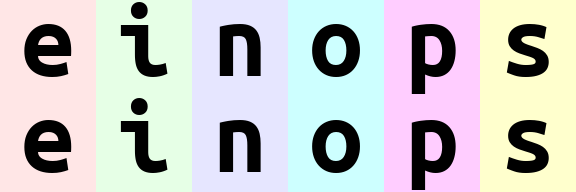

In [10]:
repeat(ims, 'b h w c -> (repeat h) (b w) c', repeat=2)

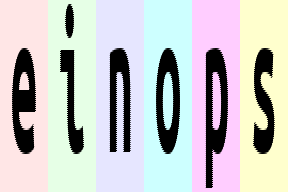

In [11]:
rearrange(ims, 'b h (w1 w2) c -> (h w2) (b w1) c', w2=2)

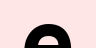

In [12]:
rearrange(ims, 'b (h1 h2) w c -> (b h1) h2 w c', h2=48)[0]

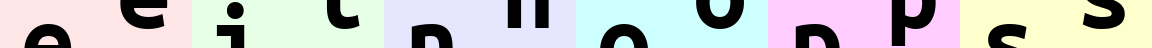

In [13]:
rearrange(ims, 'b (h1 h2) w c -> h2 (b h1 w) c', h2=48)

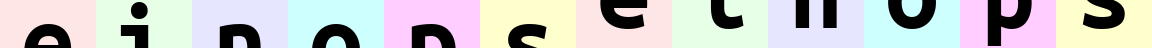

In [14]:
rearrange(ims, 'b (h1 h2) w c -> h2 (h1 b w) c', h2=48)

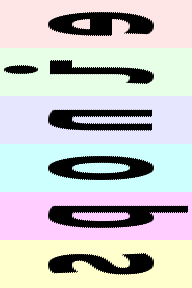

In [15]:
rearrange(ims, 'b h (w1 w2) c -> (b w1) (h w2) c', w2=2)

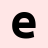

In [16]:
# rearrange(ims[0], '(h1 h2) (w1 w2) c -> (h1 w2) (w1 h2) c', h1=12, w1=12)
reduce(ims[0], '(h1 h2) (w1 w2) c -> h1 w1 c', 'mean', h2=2, w2=2)

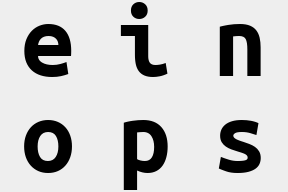

In [17]:
reduce(ims, '(b1 b2) h w c -> (b1 h) (b2 w)', 'mean', b1=2)

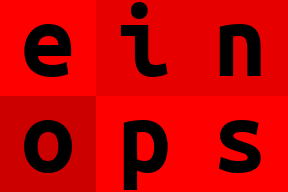

In [18]:
a = rearrange(ims, '(b1 b2) h w c -> (b1 h) (b2 w) c', b1=2)
a[:, :, 1:3] = 0
a

# repeat(a, 'h w c -> h w (l c)', l=3)

In [24]:
selected_experts = torch.randint(0, 8, (4 * 5, 2))
expert_mask = torch.nn.functional.one_hot(selected_experts, num_classes=8)
expert_mask = rearrange(expert_mask, 'b n e -> e n b')
print(f"{selected_experts=}")
print(f"{expert_mask=}")

selected_experts=tensor([[6, 4],
        [5, 5],
        [1, 6],
        [0, 3],
        [6, 1],
        [6, 2],
        [4, 4],
        [5, 5],
        [5, 0],
        [6, 2],
        [7, 3],
        [5, 1],
        [2, 7],
        [3, 5],
        [5, 2],
        [3, 7],
        [2, 0],
        [5, 4],
        [5, 4],
        [2, 2]])
expert_mask=tensor([[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   

In [1]:
import torch
from einops import rearrange

NEG_INF = -1e10  # -infinity
EPSILON = 1e-10

Q_LEN = 6
K_LEN = 6
Q_BLOCK_SIZE = 3 # 
KV_BLOCK_SIZE = 3
Tr = Q_LEN // Q_BLOCK_SIZE
Tc = K_LEN // KV_BLOCK_SIZE

Q = torch.randn(1, 1, Q_LEN, 4, requires_grad=True).to(device='cpu')
K = torch.randn(1, 1, K_LEN, 4, requires_grad=True).to(device='cpu')
V = torch.randn(1, 1, K_LEN, 4, requires_grad=True).to(device='cpu')
O = torch.zeros_like(Q, requires_grad=True)
l = torch.zeros(Q.shape[:-1])[..., None]
m = torch.ones(Q.shape[:-1])[..., None] * NEG_INF

In [4]:
Q_BLOCKS = torch.split(Q, Q_BLOCK_SIZE, dim=2)
K_BLOCKS = torch.split(K, KV_BLOCK_SIZE, dim=2)
V_BLOCKS = torch.split(V, KV_BLOCK_SIZE, dim=2)
O_BLOCKS = list(torch.split(O, Q_BLOCK_SIZE, dim=2))
l_BLOCKS = list(torch.split(l, Q_BLOCK_SIZE, dim=2))
m_BLOCKS = list(torch.split(m, Q_BLOCK_SIZE, dim=2))

In [29]:
K0 = K_BLOCKS[0]
V0 = V_BLOCKS[0]
Q0 = Q_BLOCKS[0]

S00 = torch.einsum('b h q d, b h k d -> b h q k', Q0, K0)
S00

tensor([[[[-0.2759, -1.7694,  0.8443],
          [-1.8048, -1.0213, -1.2595],
          [ 1.6117, -0.7968,  2.0172]]]], grad_fn=<ViewBackward0>)

In [32]:
torch.max(S00, dim=-1, keepdim=True)[0]

tensor([[[[ 0.8443],
          [-1.0213],
          [ 2.0172]]]], grad_fn=<MaxBackward0>)